In [1]:
from datetime import datetime

import numpy as np
import torch
from gym.wrappers import (
    FilterObservation,
    FlattenObservation,
    FrameStack,
    RecordVideo,
    RescaleAction,
    TimeLimit,
)
from stable_baselines3.common.env_util import unwrap_wrapper

from bayesopt import calculate_objective, get_next_samples, scale_action
from ea_optimize import (
    ARESEADOOCS,
    CallbackList,
    OptimizeFunctionCallback,
    report_ea_optimization_to_logbook,
)
from utils import (
    FilterAction,
    NotVecNormalize,
    PolishedDonkeyCompatibility,
    RecordEpisode,
    send_to_elog,
)


initializing ocelot...


## Preamble

Remarks: I would set a higher max_step for BO, maybe 100/150?

In [2]:
config = config = {
    "action_mode": "direct",    #_unidirectional_quads",
    "gamma": 0.99,
    # "filter_action": [0, 1, 3],
    "filter_action": None,
    "filter_observation": None,
    "frame_stack": None,
    "incoming_mode": "random",
    "incoming_values": None,
    "magnet_init_mode": "constant",
    "magnet_init_values": np.array([10, -10, 0, 10, 0]),
    "misalignment_mode": "constant",
    "misalignment_values": np.zeros(8),
    "n_envs": 40,
    "normalize_observation": True,
    "normalize_reward": True,
    "rescale_action": (-3, 3),
    "reward_mode": "logl1",
    "sb3_device": "auto",
    "target_beam_mode": "constant",
    "target_beam_values": np.zeros(4),
    "target_mu_x_threshold": 1e-5,
    "target_mu_y_threshold": 1e-5,
    "target_sigma_x_threshold": 1e-5,
    "target_sigma_y_threshold": 1e-5,
    "threshold_hold": 5,
    "time_limit": 50000,
    "vec_env": "subproc",
    "w_done": 0.0,
    "w_mu_x": 1.0,
    "w_mu_x_in_threshold": 0.0,
    "w_mu_y": 1.0,
    "w_mu_y_in_threshold": 0.0,
    "w_on_screen": 0.0,
    "w_sigma_x": 1.0,
    "w_sigma_x_in_threshold": 0.0,
    "w_sigma_y": 1.0,
    "w_sigma_y_in_threshold": 0.0,
    "w_time": 0.0,
}


In [3]:
# define a similar optimize function as in ea_optimize.py
def optimize(
    target_mu_x,
    target_sigma_x,
    target_mu_y,
    target_sigma_y,
    target_mu_x_threshold=3.3198e-6,
    target_mu_y_threshold=3.3198e-6,
    target_sigma_x_threshold=3.3198e-6,
    target_sigma_y_threshold=3.3198e-6,
    max_steps=100,
    model_name="BO",
    logbook=False,
    callback=None,
    obj_function="logmae",
    acquisition="EI",
    init_x=None,
    init_samples=5,
    filter_action=None,
):
    # Create the environment
    env = ARESEADOOCS(
        action_mode=config["action_mode"],
        magnet_init_mode=config["magnet_init_mode"],
        magnet_init_values=config["magnet_init_values"],
        reward_mode=config["reward_mode"],
        target_beam_mode=config["target_beam_mode"],
        target_beam_values=np.array(
            [target_mu_x, target_sigma_x, target_mu_y, target_sigma_y]
        ),
        target_mu_x_threshold=target_mu_x_threshold,
        target_mu_y_threshold=target_mu_y_threshold,
        target_sigma_x_threshold=target_sigma_x_threshold,
        target_sigma_y_threshold=target_sigma_y_threshold,
        threshold_hold=1,
        w_done=config["w_done"],
        w_mu_x=config["w_mu_x"],
        w_mu_x_in_threshold=config["w_mu_x_in_threshold"],
        w_mu_y=config["w_mu_y"],
        w_mu_y_in_threshold=config["w_mu_y_in_threshold"],
        w_on_screen=config["w_on_screen"],
        w_sigma_x=config["w_sigma_x"],
        w_sigma_x_in_threshold=config["w_sigma_x_in_threshold"],
        w_sigma_y=config["w_sigma_y"],
        w_sigma_y_in_threshold=config["w_sigma_y_in_threshold"],
        w_time=config["w_time"],
    )
    if max_steps is not None:
        env = TimeLimit(env, max_steps)
    if callback is not None:
        env = OptimizeFunctionCallback(env, callback)
    env = RecordEpisode(env)
    if config["filter_observation"] is not None:
        env = FilterObservation(env, config["filter_observation"])
    if config["filter_action"] is not None:
        env = FilterAction(env, config["filter_action"], replace=0)
    env = FlattenObservation(env)
    if config["frame_stack"] is not None:
        env = FrameStack(env, config["frame_stack"])
    if config["rescale_action"] is not None:
        env = RescaleAction(
            env, config["rescale_action"][0], config["rescale_action"][1]
        )
    env = RecordVideo(env, video_folder=f"recordings_real/{datetime.now():%Y%m%d%H%M}")
    # env = NotVecNormalize(env, f"models/{model_name}/vec_normalize.pkl")

    callback = CallbackList(callback) if isinstance(callback, list) else callback

    # Actual optimisation
    t_start = datetime.now()
    observation = env.reset()
    beam_image_before = env.get_beam_image()
    done = False

    # Initialization
    x_dim = env.action_space.shape[0]
    bounds = torch.tensor(
        np.array([env.action_space.low, env.action_space.high]), dtype=torch.float32
    )
    if init_x is not None:  # From fix starting points
        X = torch.tensor(init_x.reshape(-1, x_dim), dtype=torch.float32)
    else:  # Random Initialization-5.7934
        action_i = scale_action(env, observation, filter_action)
        X = torch.tensor([action_i], dtype=torch.float32)
        for i in range(init_samples - 1):
            X = torch.cat([X, torch.tensor([env.action_space.sample()])])
    # Sample initial Ys to build GP
    Y = torch.empty((X.shape[0], 1))
    for i, action in enumerate(X):
        action = action.detach().numpy()
        print(f"Collecting initial Ys step {i} at {action = }")
        observation, reward, done, info = env.step(action)
        objective = calculate_objective(env, observation, reward, obj=obj_function)
        Y[i] = torch.tensor(objective)

    # Actual BO Loop
    jans_i = 0
    while not done:
        # action, _ = model.predict(observation, deterministic=True)
        action_t = get_next_samples(
            X, Y, Y.max(), bounds, n_points=1, acquisition=acquisition
        )
        action = action_t.detach().numpy().flatten()
        print(f"Actual optimisation exploring step {jans_i} {action = }")
        jans_i += 1
        observation, reward, done, info = env.step(action)
        objective = calculate_objective(env, observation, reward, obj=obj_function)

        # append data
        X = torch.cat([X, action_t])
        Y = torch.cat([Y, torch.tensor([[objective]], dtype=torch.float32)])

    t_end = datetime.now()

    recording = unwrap_wrapper(env, RecordEpisode)
    if logbook:
        report_ea_optimization_to_logbook(
            model_name,
            t_start,
            t_end,
            recording.observations,
            recording.infos,
            beam_image_before,
            target_mu_x_threshold,
            target_sigma_x_threshold,
            target_mu_y_threshold,
            target_sigma_y_threshold,
        )

    env.close()


## Actual BO

/tmp/ipykernel_2938498/3954147879.py:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  X = torch.cat([X, torch.tensor([env.action_space.sample()])])


       -3.3378601e-06], dtype=float32)
      dtype=float32)
      dtype=float32)
      dtype=float32)
      dtype=float32)
Actual optimisation exploring step 0 action = array([ 0.05255985, -1.29063   , -1.4607413 ,  0.20335865, -0.6377983 ],
      dtype=float32)
Actual optimisation exploring step 1 action = array([-1.0552585 , -2.3906062 , -1.2718534 , -0.07474494, -1.2854301 ],
      dtype=float32)
Actual optimisation exploring step 2 action = array([ 0.37451696, -2.485188  , -2.3564076 , -0.5100455 ,  1.6099272 ],
      dtype=float32)
Actual optimisation exploring step 3 action = array([-0.47950888,  0.3052001 ,  2.1373367 ,  2.5693288 ,  2.2792807 ],
      dtype=float32)
Actual optimisation exploring step 4 action = array([-0.15218687, -1.8431761 , -1.9575719 , -0.41325355,  1.9860592 ],
      dtype=float32)
Actual optimisation exploring step 5 action = array([-0.6789825, -2.3414958, -1.7214549,  1.2157016,  2.8102207],
      dtype=float32)
Actual optimisation exploring step 6 actio

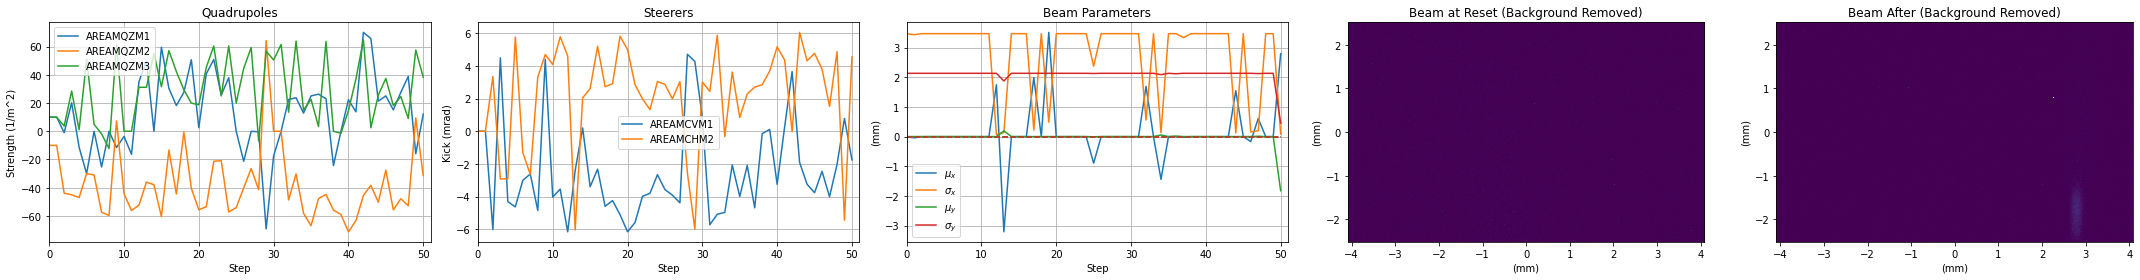

In [4]:
# hopefully this would run :)

optimize(
    target_mu_x=0.0,    # 0.4249e-3,
    target_sigma_x=0.0,
    target_mu_y=0.0,    # 1.1048e-3,
    target_sigma_y=0.0,
    target_mu_x_threshold=3.16e-6,
    target_mu_y_threshold=3.16e-6,
    target_sigma_x_threshold=3.16e-6,
    target_sigma_y_threshold=3.16e-6,
    max_steps=50,
    model_name="BO",
    logbook=True,
    callback=None,
    obj_function="logmae",
    acquisition="EI",
    init_x=None,
    init_samples=5,
    filter_action=None,
)
